In [2]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array, collatev2
import winsound
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.19 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [3]:
import logging
logger = logging.getLogger('andy')
fh = logging.FileHandler('andy.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 5)

In [5]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice
0,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,8,1,1
1,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,9,1,1
2,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,11,1,1
3,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,12,1,1
4,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,15,1,1
...,...,...,...,...,...
359,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1
360,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,26,1,1
361,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,24,1,1
362,C:\Users\araza\Documents\1\gits\thesis_project...,C:\Users\araza\Documents\1\gits\thesis_project...,25,1,1


In [6]:
transform = NiftiToTensorTransform(target_shape = (300, 300), rpn_mode=True) # Hanggang dito lang kaya ng GPU mem ko

cases = data.mri
masks = data.masks
target = data.target

In [7]:
dataset = VALDODataset(
    cases=cases,
    masks=masks,
    target=target,
    transform=transform,
    normalization=z_score_normalization,
)

In [8]:
dloader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=1,
    collate_fn=collatev2,
)

### Config for fitter

In [9]:
from project.model import RPN

config = {
    'model': RPN(
        input_dim=2500,
        output_dim=4,
        image_size=300
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 5,
    # 'loss': nn.SmoothL1Loss(),
    'loss': nn.MSELoss(),
    'lr': 0.00001
}

1369


C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Load Pretrained Embedder

### Load RPN Weights

In [10]:
model = config['model']
model.load_state_dict(torch.load('RPN_weights_241024213949.pt'))

<All keys matched successfully>

### Sample trial

In [11]:
sample = next(enumerate(dloader))

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [35]:
slices, masks, target, case = sample[1][0]

In [36]:
masks[target]/300

tensor([[[0.5352, 0.5430, 0.5801, 0.5879]]], dtype=torch.float64)

In [37]:
masks[target]

tensor([[[160.5469, 162.8906, 174.0234, 176.3672]]], dtype=torch.float64)

In [38]:
slices = slices.squeeze(1).float().to(device)
masks = masks.squeeze(1).float().to(device)

In [40]:
y = model(slices, target)

In [42]:
y*300

tensor([[159.2433, 107.5304,  15.7346, 178.5749]], device='cuda:0',
       grad_fn=<MulBackward0>)

### Fitter

In [9]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)
                Y.append(y)
                T.append(masks[target])
                self.log(memcheck())
                # memcheck()
                # del x, y, masks, slices
                # torch.cuda.empty_cache()
                # memcheck()
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += len(batch)
            if counter % 100 == 0:
                self.log(f'Progress:\t{counter}/{len(dataset)}')
                self.log(f'Current error:\t{losses}')
            
            loss_history.append(losses.detach().cpu().numpy())
            
            # del losses, Y, T
            # torch.cuda.empty_cache()
            # logger.info(f'MEMORY after CLEARING MEMORY\t{memcheck()}')
        
        return loss_history

In [10]:
fitter = RPNFitter(config, logger=logger)

### Training

In [11]:
hist = fitter.fit(dloader, dloader)

INFO:andy:EPOCH 0 ==============================
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:andy:----------------- BATCH -----------------
C:\Program Files\Python310\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Program Files\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
INFO:andy:(508836864, 591396864)
pixdim[0] (qfac) should be 1 (default) or -1; set

In [12]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

torch.Size([5, 364])


<Axes: >

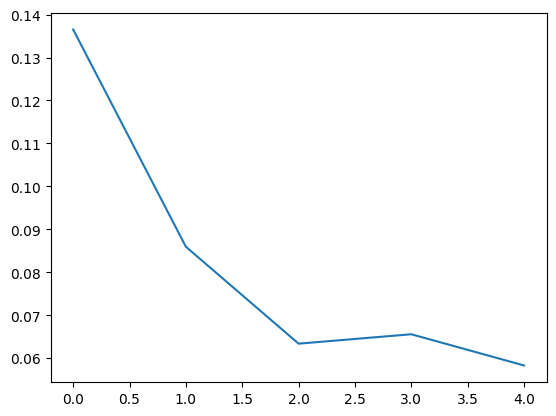

In [13]:
import seaborn as sns
import numpy as np

h = torch.tensor(np.array(hist))
print(h.shape)
sns.lineplot(h.mean(1))

In [14]:
h.view(-1)

tensor([0.4876, 0.2136, 0.2188,  ..., 0.0422, 0.0299, 0.0187])

In [16]:
h.shape

torch.Size([5, 364])

### Save the weights

In [17]:
model = config['model']

In [23]:
import datetime

s = f'RPN_weights_{datetime.datetime.now().strftime("%d%m%y%H%M%S")}.pt'
s

'RPN_weights_241024213949.pt'

In [24]:
model = config['model']

In [25]:
torch.save(model.state_dict(), s)

# Summary

normalization of output helps

# Trial